In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
import sqlite3
warnings.filterwarnings("ignore")

logging.set_verbosity_error()


In [2]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True


seed_everything(86)


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 10
N_SPLITS = 5


In [4]:
conn_train = sqlite3.connect("../Data/generate_data/data_train.db")
crs_train = conn_train.cursor()
data_train = pd.read_sql_query("SELECT * FROM data", conn_train)

conn_test = sqlite3.connect("../Data/generate_data/data_test.db")
crs_test = conn_test.cursor()
data_test = pd.read_sql_query("SELECT * FROM data", conn_test)

train_df = pd.DataFrame()
train_df['title'] = data_train.Posts
train_df['label'] = data_train['Emotion']

test_df = pd.DataFrame()
test_df['title'] = data_test.Posts
test_df['label'] = data_test['Emotion']

skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.label)):
    train_df.loc[val_, "kfold"] = fold


In [5]:
train_df.sample(5)


,title,label,kfold
7661,"Mỗi con người đều sẽ mệt mỏi, có lẽ là mệt mỏi...",5,2.0
2574,"Tôi từng viết ba bài trên Hẹn hò, giờ đã tìm đ...",4,1.0
338,Không phải cứ đêm thì nỗi buồn sẽ tới nhiều h...,0,1.0
5320,'Không cần phải nói rất nhiều về sự kỳ lạ tro...,2,4.0
556,POST HỘ\nChào mọi người. Giờ con gái mình đã 1...,1,0.0


In [6]:
train_df.info(), test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8501 entries, 0 to 8500
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   8499 non-null   object 
 1   label   8501 non-null   int64  
 2   kfold   8501 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 199.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1501 non-null   object
 1   label   1501 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.6+ KB


(None, None)

<AxesSubplot:xlabel='label', ylabel='count'>

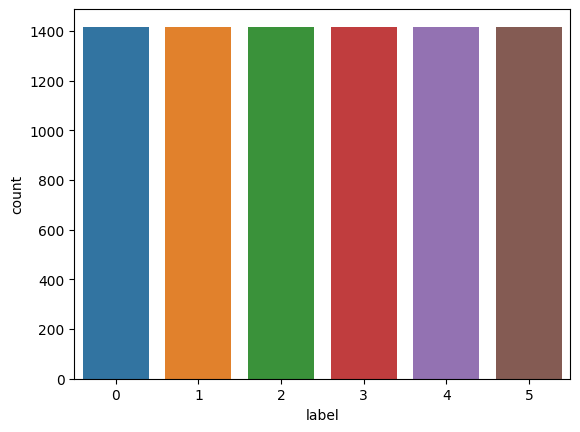

In [7]:
sns.countplot(x='label', data=train_df)


In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    "vinai/phobert-base", use_fast=False, from_tf=True)


In [9]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=4096):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['title']
        text = ' '.join(simple_preprocess(text))
        label = row['label']

        return text, label


Text(0.5, 9.444444444444438, 'Token Count')

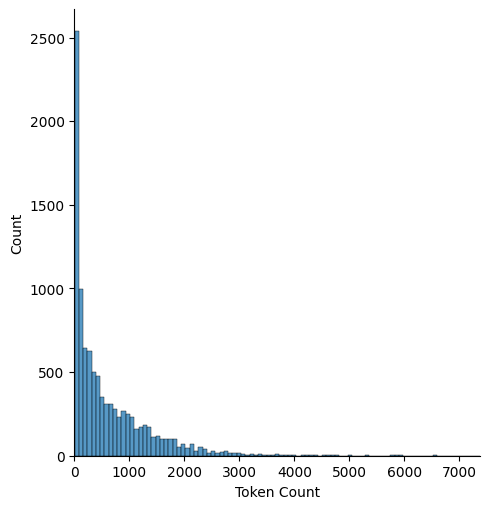

In [10]:
# Distribution of length of Sentence
all_data = train_df.title.tolist() + test_df.title.tolist()
all_data = [' '.join(simple_preprocess(str(text))) for text in all_data]
encoded_text = [tokenizer.encode(
    text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0, max(token_lens)])
plt.xlabel('Token Count')


In [11]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(
            "vinai/phobert-base", from_tf=True)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False  # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x


In [12]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(
        f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')


def eval(test_data=False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(
            f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(
            f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)


In [14]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_loader)*EPOCHS
    )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc


-----------Fold: 1 ------------------


Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Epoch 1/10
------------------------------


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/maddie/Desktop/DATN/HoangPhiLong/Code/env/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/maddie/Desktop/DATN/HoangPhiLong/Code/env/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'SentimentDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [ ]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=7)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts


In [ ]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=4096)
test_loader = DataLoader(test_dataset, batch_size=64,
                         shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)


In [ ]:
def infer(text, tokenizer, max_len=4096):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')
